## Interest Rate Spreads

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import bewleymethods as bm
from numba import vectorize, guvectorize, njit


r_h = 0.06
r_l = 0.03
gamma = 1.2 
rho = 0.05

y1 = 0.1
y2 = 0.2
y = np.array([y1, y2])
l1 = 1.5
l2 = 1
la = [l1,l2]
La = np.array([[-l1,l2],[l1,-l2]])



### 1. Steady State Analysis

In [90]:
I = 500
J = 2
Delta = 0.01

amax = 1
amin = -0.2
a = bm.agrid(amin, amax, I)
ind = a < 0
da = a[2] - a[1]

v =(y[:,np.newaxis] + r_l*a)**(1-gamma)/(1-gamma)/rho
v = np.transpose(v)

dVf = np.zeros([I,J])
dVb = np.zeros([I,J])
sf = np.zeros([I,J])
sb = np.zeros([I,J])
cf = np.zeros([I,J])
cb = np.zeros([I,J])
c0 = np.zeros([I,J])
s = np.zeros([I,J])
c = np.zeros([I,J])

g0 = np.ones([I,J])/(I*J)

tol = 1e-10
diff = 1 

while diff > tol:
    V = v
    dVf[0:I-1,:] = (V[1:I,:] - V[0:I-1,:])/da
    dVf[I-1,:] = 0
    dVb[1:I,:] = (V[1:I,:] - V[0:I-1,:])/da
    dVb[0,:] = (y[np.newaxis,:] + r_h*amin)**(-gamma)

    cf = dVf**(-1/gamma)
    sf[ind] = np.transpose(y[:,np.newaxis] + r_h*a[ind]) - cf[ind]
    sf[np.sum(ind):I] = np.transpose(y[:,np.newaxis] + r_l*a[np.sum(ind):I]) - cf[np.sum(ind):I]
    cb = dVb**(-1/gamma)
    sb[ind] = np.transpose(y[:,np.newaxis] + r_h*a[ind]) - cb[ind]
    sb[np.sum(ind):I] = np.transpose(y[:,np.newaxis] + r_l*a[np.sum(ind):I]) - cb[np.sum(ind):I]
    c0[ind] = np.transpose(y[:,np.newaxis] + r_h*a[ind])
    c0[np.sum(ind):I] = np.transpose(y[:,np.newaxis] + r_l*a[np.sum(ind):I])
    dV0 = c0**(-gamma)

    iF = sf > 0
    iB = sb < 0
    i0 = 1 - iF - iB
    iF[I-1,:] = 0
    iB[I-1,:] = 1

    dV = dVf*iF + dVb*iB + dV0*i0
    c = dV**(-1/gamma)
    s[ind] = np.transpose(y[:,np.newaxis] + r_h*a[ind]) - c[ind]
    s[np.sum(ind):I] = np.transpose(y[:,np.newaxis] + r_l*a[np.sum(ind):I]) - c[np.sum(ind):I]
    h = c**(1-gamma)/(1-gamma) + s*dV

    Vi = (h - rho*V + V@La)*Delta + V
    diff = np.max(abs(Vi-V))
    v = Vi
    for j in range(100):
        dVf[0:I-1,:] = (v[1:I,:] - v[0:I-1,:])/da
        dVf[I-1,:] = 0 
        dVb[1:I,:] = (v[1:I,:] - v[0:I-1,:])/da
        dVb[0,:] = (y[np.newaxis,:] + r_h*amin)**(-gamma)
        dV = dVf*iF + dVb*iB + dV0*i0
        h = c**(1-gamma)/(1-gamma) + s*dV
        v = (h - rho*v + v@La)*Delta + v

    

/Users/matiasbayas-erazo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in power
/Users/matiasbayas-erazo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in power
/Users/matiasbayas-erazo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in power
/Users/matiasbayas-erazo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/matiasbayas-erazo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in less


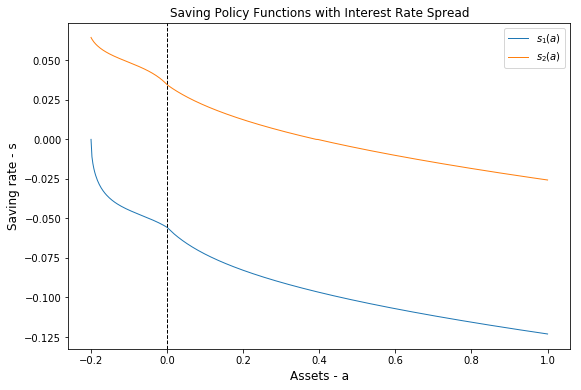

In [91]:
plt.figure(figsize=(9,6))
plt.plot(a,s, linewidth = 1)
plt.axvline(x=0,linewidth=1, color='k', linestyle = '--')
plt.xlabel('Assets - a', fontsize=12)
plt.ylabel('Saving rate - s', fontsize=12)
plt.title('Saving Policy Functions with Interest Rate Spread', fontsize=12)
plt.gca().legend(('$s_1(a)$','$s_2(a)$'), loc = 'best')
plt.savefig('savings1.eps', format='eps')

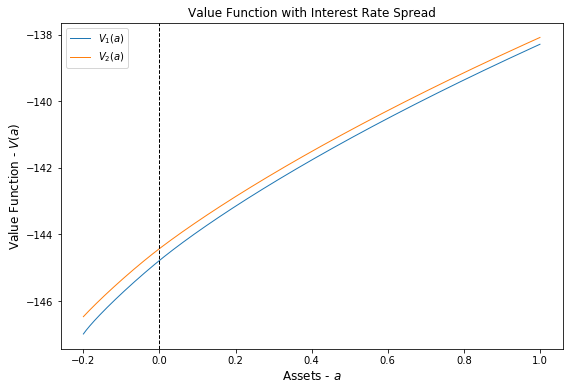

In [92]:
plt.figure(figsize=(9,6))
plt.plot(a,v, linewidth = 1)
plt.axvline(x=0,linewidth=1, color='k', linestyle = '--')
plt.xlabel('Assets - $a$', fontsize=12)
plt.ylabel('Value Function - $V(a)$', fontsize=12)
plt.title('Value Function with Interest Rate Spread', fontsize=12)
plt.gca().legend(('$V_1(a)$','$V_2(a)$'), loc = 'best')
plt.show()

In [93]:
D = bm.solveD(g0, La, s, Delta = 0.01, da = a[1] - a[0])

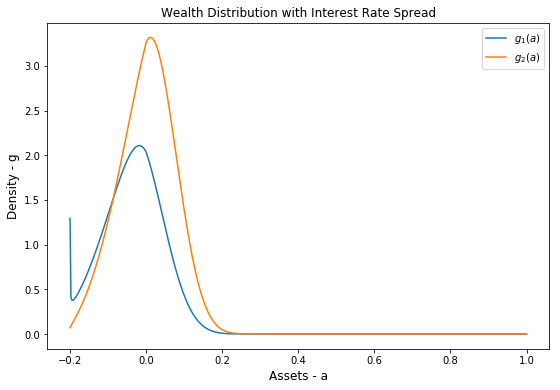

In [94]:
plt.figure(figsize=(9,6))
plt.plot(a,D/da)
plt.xlabel('Assets - a', fontsize=12)
plt.ylabel('Density - g', fontsize=12)
plt.title('Wealth Distribution with Interest Rate Spread', fontsize=12)
plt.gca().legend(('$g_1(a)$','$g_2(a)$'), loc = 'best')
plt.savefig('distpy.eps', format='eps')

### 2. Transition Dynamics

In [65]:
T = 30
spread0 = 1.1
rl0 = 0.03
rh0 = rl0*spread0

spreadT = 2
rlT = 0.03
rhT = rlT*spreadT

In [66]:
rs = np.zeros([2,T])
rs[:,0] = rh0, rl0
for t in range(1,T):
    rs[:,t] = rhT, rlT
    

In [67]:
Vs = np.empty((T,I,J))
Cs = np.empty((T,I,J))
Ss = np.empty((T,I,J))
Ds = np.empty((T,I,J))

In [68]:
# Final steady state:

r_h = rs[0,T-1]
r_l = rs[1,T-1]

v =(y[:,np.newaxis] + r_l*a)**(1-gamma)/(1-gamma)/rho
v = np.transpose(v)

dVf = np.zeros([I,J])
dVb = np.zeros([I,J])
sf = np.zeros([I,J])
sb = np.zeros([I,J])
cf = np.zeros([I,J])
cb = np.zeros([I,J])
c0 = np.zeros([I,J])
s = np.zeros([I,J])
c = np.zeros([I,J])

tol = 1e-10
diff = 1 

while diff > tol:
    V = v
    dVf[0:I-1,:] = (V[1:I,:] - V[0:I-1,:])/da
    dVf[I-1,:] = 0
    dVb[1:I,:] = (V[1:I,:] - V[0:I-1,:])/da
    dVb[0,:] = (y[np.newaxis,:] + r_h*amin)**(-gamma)

    cf = dVf**(-1/gamma)
    sf[ind] = np.transpose(y[:,np.newaxis] + r_h*a[ind]) - cf[ind]
    sf[np.sum(ind):I] = np.transpose(y[:,np.newaxis] + r_l*a[np.sum(ind):I]) - cf[np.sum(ind):I]
    cb = dVb**(-1/gamma)
    sb[ind] = np.transpose(y[:,np.newaxis] + r_h*a[ind]) - cb[ind]
    sb[np.sum(ind):I] = np.transpose(y[:,np.newaxis] + r_l*a[np.sum(ind):I]) - cb[np.sum(ind):I]
    c0[ind] = np.transpose(y[:,np.newaxis] + r_h*a[ind])
    c0[np.sum(ind):I] = np.transpose(y[:,np.newaxis] + r_l*a[np.sum(ind):I])
    dV0 = c0**(-gamma)

    iF = sf > 0
    iB = sb < 0
    i0 = 1 - iF - iB
    iF[I-1,:] = 0
    iB[I-1,:] = 1

    dV = dVf*iF + dVb*iB + dV0*i0
    c = dV**(-1/gamma)
    s[ind] = np.transpose(y[:,np.newaxis] + r_h*a[ind]) - c[ind]
    s[np.sum(ind):I] = np.transpose(y[:,np.newaxis] + r_l*a[np.sum(ind):I]) - c[np.sum(ind):I]
    h = c**(1-gamma)/(1-gamma) + s*dV

    Vi = (h - rho*V + V@La)*Delta + V
    diff = np.max(abs(Vi-V))
    v = Vi
    for j in range(100):
        dVf[0:I-1,:] = (v[1:I,:] - v[0:I-1,:])/da
        dVf[I-1,:] = 0 
        dVb[1:I,:] = (v[1:I,:] - v[0:I-1,:])/da
        dVb[0,:] = (y[np.newaxis,:] + r_h*amin)**(-gamma)
        dV = dVf*iF + dVb*iB + dV0*i0
        h = c**(1-gamma)/(1-gamma) + s*dV
        v = (h - rho*v + v@La)*Delta + v

Vs[T-1] = v
Ss[T-1] = s
Cs[T-1] = c


/Users/matiasbayas-erazo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in power
/Users/matiasbayas-erazo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in power
/Users/matiasbayas-erazo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in power
/Users/matiasbayas-erazo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in greater
/Users/matiasbayas-erazo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less


In [69]:
# Initial distribution:

r_h = rs[0,0]
r_l = rs[1,0]

v =(y[:,np.newaxis] + r_l*a)**(1-gamma)/(1-gamma)/rho
v = np.transpose(v)

dVf = np.zeros([I,J])
dVb = np.zeros([I,J])
sf = np.zeros([I,J])
sb = np.zeros([I,J])
cf = np.zeros([I,J])
cb = np.zeros([I,J])
c0 = np.zeros([I,J])
s = np.zeros([I,J])
c = np.zeros([I,J])

tol = 1e-10
diff = 1 

while diff > tol:
    V = v
    dVf[0:I-1,:] = (V[1:I,:] - V[0:I-1,:])/da
    dVf[I-1,:] = 0
    dVb[1:I,:] = (V[1:I,:] - V[0:I-1,:])/da
    dVb[0,:] = (y[np.newaxis,:] + r_h*amin)**(-gamma)

    cf = dVf**(-1/gamma)
    sf[ind] = np.transpose(y[:,np.newaxis] + r_h*a[ind]) - cf[ind]
    sf[np.sum(ind):I] = np.transpose(y[:,np.newaxis] + r_l*a[np.sum(ind):I]) - cf[np.sum(ind):I]
    cb = dVb**(-1/gamma)
    sb[ind] = np.transpose(y[:,np.newaxis] + r_h*a[ind]) - cb[ind]
    sb[np.sum(ind):I] = np.transpose(y[:,np.newaxis] + r_l*a[np.sum(ind):I]) - cb[np.sum(ind):I]
    c0[ind] = np.transpose(y[:,np.newaxis] + r_h*a[ind])
    c0[np.sum(ind):I] = np.transpose(y[:,np.newaxis] + r_l*a[np.sum(ind):I])
    dV0 = c0**(-gamma)

    iF = sf > 0
    iB = sb < 0
    i0 = 1 - iF - iB
    iF[I-1,:] = 0
    iB[I-1,:] = 1

    dV = dVf*iF + dVb*iB + dV0*i0
    c = dV**(-1/gamma)
    s[ind] = np.transpose(y[:,np.newaxis] + r_h*a[ind]) - c[ind]
    s[np.sum(ind):I] = np.transpose(y[:,np.newaxis] + r_l*a[np.sum(ind):I]) - c[np.sum(ind):I]
    h = c**(1-gamma)/(1-gamma) + s*dV

    Vi = (h - rho*V + V@La)*Delta + V
    diff = np.max(abs(Vi-V))
    v = Vi
    for j in range(100):
        dVf[0:I-1,:] = (v[1:I,:] - v[0:I-1,:])/da
        dVf[I-1,:] = 0 
        dVb[1:I,:] = (v[1:I,:] - v[0:I-1,:])/da
        dVb[0,:] = (y[np.newaxis,:] + r_h*amin)**(-gamma)
        dV = dVf*iF + dVb*iB + dV0*i0
        h = c**(1-gamma)/(1-gamma) + s*dV
        v = (h - rho*v + v@La)*Delta + v

Ds[0] = bm.solveD(g0, La, s, Delta = 0.01, da = a[1] - a[0])

/Users/matiasbayas-erazo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in power
/Users/matiasbayas-erazo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in power
/Users/matiasbayas-erazo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in power
/Users/matiasbayas-erazo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in greater
/Users/matiasbayas-erazo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less


In [70]:
# Solve backward to get value functions:
for t in range(T-1,0,-1):
    
    dVf = np.zeros([I,J])
    dVb = np.zeros([I,J])
    sf = np.zeros([I,J])
    sb = np.zeros([I,J])
    cf = np.zeros([I,J])
    cb = np.zeros([I,J])
    c0 = np.zeros([I,J])
    s = np.zeros([I,J])
    c = np.zeros([I,J])
    
    V = Vs[t]
    r_h = rs[0,t-1]
    r_l = rs[1,t-1]
    dVf[0:I-1,:] = (V[1:I,:] - V[0:I-1,:])/da
    dVf[I-1,:] = 0
    dVb[1:I,:] = (V[1:I,:] - V[0:I-1,:])/da
    dVb[0,:] = (y[np.newaxis,:] + r_h*amin)**(-gamma)

    cf = dVf**(-1/gamma)
    sf[ind] = np.transpose(y[:,np.newaxis] + r_h*a[ind]) - cf[ind]
    sf[np.sum(ind):I] = np.transpose(y[:,np.newaxis] + r_l*a[np.sum(ind):I]) - cf[np.sum(ind):I]
    cb = dVb**(-1/gamma)
    sb[ind] = np.transpose(y[:,np.newaxis] + r_h*a[ind]) - cb[ind]
    sb[np.sum(ind):I] = np.transpose(y[:,np.newaxis] + r_l*a[np.sum(ind):I]) - cb[np.sum(ind):I]
    c0[ind] = np.transpose(y[:,np.newaxis] + r_h*a[ind])
    c0[np.sum(ind):I] = np.transpose(y[:,np.newaxis] + r_l*a[np.sum(ind):I])
    dV0 = c0**(-gamma)

    iF = sf > 0
    iB = sb < 0
    i0 = 1 - iF - iB
    iF[I-1,:] = 0
    iB[I-1,:] = 1

    dV = dVf*iF + dVb*iB + dV0*i0
    c = dV**(-1/gamma)
    s[ind] = np.transpose(y[:,np.newaxis] + r_h*a[ind]) - c[ind]
    s[np.sum(ind):I] = np.transpose(y[:,np.newaxis] + r_l*a[np.sum(ind):I]) - c[np.sum(ind):I]
    h = c**(1-gamma)/(1-gamma) + s*dV

    Vi = (h - rho*V + V@La)*Delta + V
    
    Vs[t-1] = Vi
    Ss[t-1] = s
    Cs[t-1] = c

/Users/matiasbayas-erazo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in power


In [71]:
# Solve forward to get distribution
for t in range(1,T):
    Ds[t] = bm.forwarditerateD(Ds[t-1], La, Ss[t-1], Delta = 0.01, da = a[1] - a[0])
    

In [72]:
# Compute aggregates:
aggC = [np.vdot(Ds[i],Cs[i])*da for i in range(T-1) ]
aggA = np.array([np.vdot(Ds[i][:,0],a)*da + np.vdot(Ds[i][:,1],a)*da
                 for i in range(T-1)])

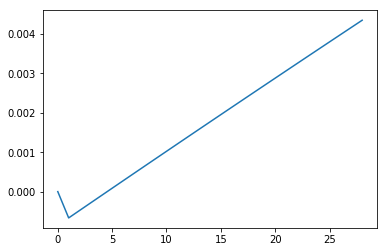

In [73]:
plt.plot((aggC-aggC[0])/aggC[0])
plt.show()

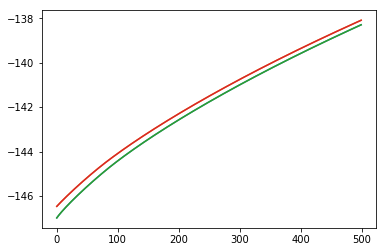

In [76]:
plt.plot(Vs[29])
plt.plot(Vs[0])
plt.show()

In [77]:
Vs

array([[[-146.99009667, -146.47031004],
        [-146.95167579, -146.44074322],
        [-146.91515222, -146.41152213],
        ...,
        [-138.3177383 , -138.11291366],
        [-138.30522395, -138.10055051],
        [-138.29271891, -138.08819637]],

       [[-146.99105925, -146.47097432],
        [-146.95253055, -146.44139181],
        [-146.9159538 , -146.41215644],
        ...,
        [-138.3177383 , -138.11291366],
        [-138.30522395, -138.10055051],
        [-138.29271891, -138.08819637]],

       [[-146.99105925, -146.47097432],
        [-146.95253055, -146.44139181],
        [-146.9159538 , -146.41215644],
        ...,
        [-138.3177383 , -138.11291366],
        [-138.30522395, -138.10055051],
        [-138.29271891, -138.08819637]],

       ...,

       [[-146.99105925, -146.47097432],
        [-146.95253056, -146.44139181],
        [-146.9159538 , -146.41215644],
        ...,
        [-138.3177383 , -138.11291366],
        [-138.30522396, -138.10055051],
        [

In [34]:
Ss[0]

array([[ 0.00000000e+00,  6.81568671e-02],
       [-6.62643897e-03,  6.69708192e-02],
       [-1.10296574e-02,  6.59670282e-02],
       [-1.42176166e-02,  6.50787632e-02],
       [-1.67678680e-02,  6.42745356e-02],
       [-1.89094172e-02,  6.35357506e-02],
       [-2.07613525e-02,  6.28500843e-02],
       [-2.23950705e-02,  6.22087598e-02],
       [-2.38573844e-02,  6.16052077e-02],
       [-2.51809515e-02,  6.10343289e-02],
       [-2.63896174e-02,  6.04920525e-02],
       [-2.75014139e-02,  5.99750558e-02],
       [-2.85303610e-02,  5.94805767e-02],
       [-2.94876076e-02,  5.90062840e-02],
       [-3.03821877e-02,  5.85501853e-02],
       [-3.12215375e-02,  5.81105586e-02],
       [-3.20118613e-02,  5.76859010e-02],
       [-3.27583965e-02,  5.72748902e-02],
       [-3.34656094e-02,  5.68763536e-02],
       [-3.41373435e-02,  5.64892444e-02],
       [-3.47769326e-02,  5.61126222e-02],
       [-3.53872895e-02,  5.57456380e-02],
       [-3.59709756e-02,  5.53875204e-02],
       [-3.